# **Load dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [3]:
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [4]:
!kaggle datasets download -d skillsmuggler/amazon-ratings

amazon-ratings.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip amazon-ratings.zip

Archive:  amazon-ratings.zip
  inflating: ratings_Beauty.csv      


# **Import libraries**

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

from time import time
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
raw_data = pd.read_csv("/content/drive/MyDrive/Kaggle/ratings_Beauty.csv")
raw_data.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


# EDA and feature engineering

In [7]:
df = raw_data.copy(deep = True)

In [8]:
# Get the shape and size of the dataset
print('Shape of dataset:',df.shape)

Shape of dataset: (2023070, 4)


In [9]:
# Get more info on it
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   UserId     object 
 1   ProductId  object 
 2   Rating     float64
 3   Timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


In [10]:
# Get more statistic info on it
df.describe()

,Rating,Timestamp
count,2.023070e+06,2.023070e+06
mean,4.149036e+00,1.360389e+09
std,1.311505e+00,4.611860e+07
min,1.000000e+00,9.087552e+08
25%,4.000000e+00,1.350259e+09
50%,5.000000e+00,1.372810e+09
75%,5.000000e+00,1.391472e+09
max,5.000000e+00,1.406074e+09


In [11]:
# Check for any Null values in the dataset
df.isna().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

insight:

>The dataset comprises of 2023070 rows and 4 columns.
>
>There are NO null/missing present in the dataset.
>
>int64 datatype of timestamp column indicates that it is in Unix timestamp format where each number is the number of seconds passed after January 1, 1970 at UTC.
>
>The average rating is about 4.

In [12]:
 # checking : if there are any duplicated userId and productId combination.
 column = ['UserId', 'ProductId']
 df[df.duplicated(subset=column, keep=False)].sort_values(column).head()

,UserId,ProductId,Rating,Timestamp


There are NO Duplicate rows present.

Timestamp column:

In [13]:
# Convert the timestamp column to a readable date time format.
df['Timestamp'] = df['Timestamp'].apply(lambda ts: datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,2013-05-28
1,A3JM6GV9MNOF9X,0558925278,3.0,2012-12-14
2,A1Z513UWSAAO0F,0558925278,5.0,2014-07-07
3,A1WMRR494NWEWV,0733001998,4.0,2013-10-24
4,A3IAAVS479H7M7,0737104473,1.0,2010-05-19


In [14]:
print('Min recorded time :',df.Timestamp.min())
print('Max recorded time :',df.Timestamp.max())

Min recorded time : 1998-10-19 00:00:00
Max recorded time : 2014-07-23 00:00:00


Text(0.5, 1.0, 'year wise ratings distribution')

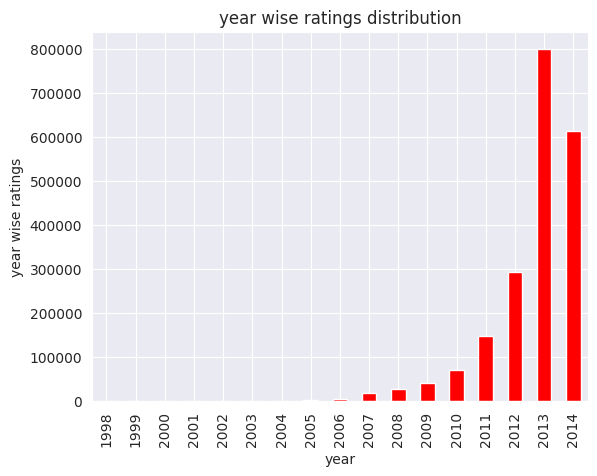

In [15]:
# Visualize the year wise ratings distribution

year_wise_count = df['Timestamp'].groupby(df['Timestamp'].dt.year).count()
year_wise_count.plot(kind='bar', color ='r')
plt.xlabel('year')
plt.ylabel('year wise ratings')
plt.title('year wise ratings distribution')

Insight:
>1.The data is collected from 1998 till 2014. And we can see every year the ratings for electronics products are increasing continuously except for an unusual hike in the year 2013 for some unknown reasons.
>
>2.After converting to readable format of datatime, it is noticed that this column doesn't contain any time component, just the date component is there.

In [16]:
# Drop the timestamp column
df.drop('Timestamp', axis=1, inplace=True)
df.head()

,UserId,ProductId,Rating
0,A39HTATAQ9V7YF,0205616461,5.0
1,A3JM6GV9MNOF9X,0558925278,3.0
2,A1Z513UWSAAO0F,0558925278,5.0
3,A1WMRR494NWEWV,0733001998,4.0
4,A3IAAVS479H7M7,0737104473,1.0


In [17]:
# Check the count of unique user and product data
unique_original = (df.UserId.nunique(), df.ProductId.nunique())
print('Count of unique Users    :', unique_original[0])
print('Count of unique Products :', unique_original[1])

Count of unique Users    : 1210271
Count of unique Products : 249274


Count of observations in each ratings:


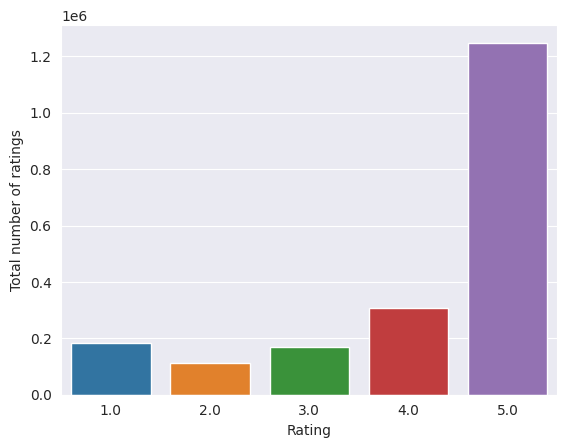

In [ ]:
# Check the distribution of ratings
print('Count of observations in each ratings:')
df['Rating'].value_counts()

g = sns.countplot(x="Rating", data=df)
g.set_ylabel("Total number of ratings")
g.set_xlabel("Rating")
g.set_title("Distribution of ratings")

plt.show()

Text(0.5, 1.0, 'year wise ratings distribution')

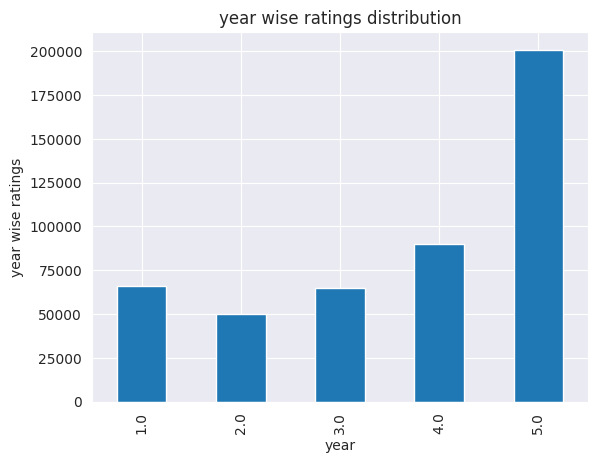

In [ ]:
# Find the unique products under each ratings
unique_product_rating=df.groupby('Rating')['ProductId'].nunique()

unique_product_rating.plot(kind='bar')
plt.xlabel('year')
plt.ylabel('year wise ratings')
plt.title('year wise ratings distribution')

Insights:

>1.Extreme high count in rating 5 indicates Amazon delivers good quality products in beauty department.
>
>2.Count plot and number of unique product under each rating category shows that there is more frequency under rating 5 followed by rating 4 and rating 1.
This means ideally people are more sensitive towards extreme experiences. In other words more ratings can be observed when users are extremely satisfied or extremely unsatisfied.
>
>3.Users do not bother to rate usually for the average experience with any product, so is the reason rating 2 and 3 are having lesser frequency compared to others.

# **Data Sparsity**

In [18]:
#I'm going to explore how many ratings have been submitted per user.
# Find the top 10 users based on ratings
most_rated = df['UserId'].value_counts().rename_axis('userId').reset_index(name='num_ratings')
most_rated.head(10)

,userId,num_ratings
0,A3KEZLJ59C1JVH,389
1,A281NPSIMI1C2R,336
2,A3M174IC0VXOS2,326
3,A2V5R832QCSOMX,278
4,A3LJLRIZL38GG3,276
5,ALQGOMOY1F5X9,275
6,AKMEY1BSHSDG7,269
7,A3R9H6OKZHHRJD,259
8,A1M04H40ZVGWVG,249
9,A1RRMZKOMZ2M7J,225


# **Density of the matrix**

In [19]:
# Find the density of the rating matrix
print('Total observed ratings in the dataset  :', len(df))
possible_num_of_ratings = df['UserId'].nunique() * df['ProductId'].nunique()
print('Total ratings possible for the dataset :', possible_num_of_ratings)
density = len(df) / possible_num_of_ratings * 100
print('Density of the dataset : {:4.5f}%'.format(density))

Total observed ratings in the dataset  : 2023070
Total ratings possible for the dataset : 301689093254
Density of the dataset : 0.00067%


In [20]:
# Drop the users who have rated less than 50 products
df = df[df['UserId'].isin(most_rated[most_rated['num_ratings'] >= 50]['userId'])]
print('number of unique USERS who have rated 50 or more products :', df['UserId'].nunique())
print('number of unique USERS dropped      :', unique_original[0] - df['UserId'].nunique())
print('number of  unique ITEMS remaining    :', df['ProductId'].nunique())
print('number of  unique ITEMS dropped      :', unique_original[1] - df['ProductId'].nunique())
print('\nFinal length of the dataset :', len(df))
df

number of unique USERS who have rated 50 or more products : 361
number of unique USERS dropped      : 1209910
number of  unique ITEMS remaining    : 17228
number of  unique ITEMS dropped      : 232046

Final length of the dataset : 29559


,UserId,ProductId,Rating
5,AKJHHD5VEH7VG,0762451459,5.0
42,A22ZFXQE8AWPEP,1304482596,1.0
47,A22ZFXQE8AWPEP,1304482685,1.0
52,A22ZFXQE8AWPEP,1304495396,1.0
61,A22ZFXQE8AWPEP,1304511111,1.0
...,...,...,...
2022999,A34GQ3JF4BGFYV,B00LH81A0I,5.0
2023024,A34BZM6S9L7QI4,B00LLPT4HI,5.0
2023026,A3NHUQ33CFH3VM,B00LLPT4HI,5.0
2023035,A1UQBFCERIP7VJ,B00LLPT4HI,5.0


In [21]:
# Find the density of the final matrix
final_ratings_matrix = df.pivot(index='UserId', columns='ProductId', values='Rating').fillna(0)
print('Shape of final_ratings_matrix          :', final_ratings_matrix.shape)
print('Total observed ratings in the dataset  :', len(df))
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('Total ratings possible for the dataset :', possible_num_of_ratings)
density = len(df) / possible_num_of_ratings * 100
print('Density of the dataset                 : {:4.2f}%'.format(density))

Shape of final_ratings_matrix          : (361, 17228)
Total observed ratings in the dataset  : 29559
Total ratings possible for the dataset : 6219308
Density of the dataset                 : 0.48%


In [22]:
final_ratings_matrix

ProductId,0762451459,1304482596,1304482685,1304495396,1304511111,1304511138,1304622665,1304624498,1304651029,130466578X,...,B00L3LB0IG,B00L3LBUGI,B00L4I5PJS,B00L5BXG36,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1047EDJ84IMAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10Y59HW4O47N0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A110PQTEI6THU7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AY9HUIJWJ8TT7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYB4ELCS5AM8P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AYOMAHLWRQHUG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Calculate the increase in density
print('The density of the user-item matrix increased by {:4.2f}%'.format((0.48-0.00067)/0.00067))

The density of the user-item matrix increased by 715.42%


The density of the user-item matrix increased by 715.42%.

In [ ]:
df

,UserId,ProductId,Rating
5,AKJHHD5VEH7VG,0762451459,5.0
42,A22ZFXQE8AWPEP,1304482596,1.0
47,A22ZFXQE8AWPEP,1304482685,1.0
52,A22ZFXQE8AWPEP,1304495396,1.0
61,A22ZFXQE8AWPEP,1304511111,1.0
...,...,...,...
2022999,A34GQ3JF4BGFYV,B00LH81A0I,5.0
2023024,A34BZM6S9L7QI4,B00LLPT4HI,5.0
2023026,A3NHUQ33CFH3VM,B00LLPT4HI,5.0
2023035,A1UQBFCERIP7VJ,B00LLPT4HI,5.0


# **Collaborative Filtering model**
>Item Based Collaborative Filtering (IBCF)

*   Compute similarity between Items

>User Based Collaborative Filtering (UBCF)

*   Compute similarity between Users


In [27]:
# Create the User-Item sparse matrix
user_item = df.pivot(index='UserId', columns='ProductId', values='Rating').fillna(0)
print('Shape of User-Item sparse matrix:', user_item.shape)
user_item.head()

Shape of User-Item sparse matrix: (361, 17228)


ProductId,0762451459,1304482596,1304482685,1304495396,1304511111,1304511138,1304622665,1304624498,1304651029,130466578X,...,B00L3LB0IG,B00L3LBUGI,B00L4I5PJS,B00L5BXG36,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1047EDJ84IMAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10G136JEISLVR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10Y59HW4O47N0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A110PQTEI6THU7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Create the Item-User sparse matrix
item_user = df.pivot(index='ProductId', columns='UserId', values='Rating').fillna(0)
print('Shape of Item-User sparse matrix:', item_user.shape)
item_user.head()

Shape of Item-User sparse matrix: (17228, 361)


UserId,A100WO06OQR8BQ,A1047EDJ84IMAS,A10G136JEISLVR,A10Y59HW4O47N0,A110PQTEI6THU7,A112TFLXGBF6NI,A11I1I9QLMAM1A,A11SWG9T60IQH8,A12PH6L5QSVTYN,A132ETQPMHQ585,...,ATV36X9V9DRB9,AV6823XS14U41,AXK3KYH8NQ9G2,AXYVSHTLWBINI,AY3D7DG5L5WCK,AY9HUIJWJ8TT7,AYB4ELCS5AM8P,AYOMAHLWRQHUG,AZ26CDSJ363AH,AZ9JPUSCI0V49
ProductId,,,,,,,,,,,,,,,,,,,,,
0762451459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1304482596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1304482685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1304495396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1304511111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Calculate the user-user similarity
user_similarity = cosine_similarity(user_item)
np.fill_diagonal(user_similarity, 0)
user_similarity_df = pd.DataFrame(user_similarity,index=user_item.index, columns=user_item.index)
user_similarity_df.head()

UserId,A100WO06OQR8BQ,A1047EDJ84IMAS,A10G136JEISLVR,A10Y59HW4O47N0,A110PQTEI6THU7,A112TFLXGBF6NI,A11I1I9QLMAM1A,A11SWG9T60IQH8,A12PH6L5QSVTYN,A132ETQPMHQ585,...,ATV36X9V9DRB9,AV6823XS14U41,AXK3KYH8NQ9G2,AXYVSHTLWBINI,AY3D7DG5L5WCK,AY9HUIJWJ8TT7,AYB4ELCS5AM8P,AYOMAHLWRQHUG,AZ26CDSJ363AH,AZ9JPUSCI0V49
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.000000,0.0,0.000000,0.0,0.175543,0.017103,0.0,0.00000,...,0.026512,0.000000,0.019341,0.0,0.178307,0.000000,0.050904,0.11968,0.019491,0.000000
A1047EDJ84IMAS,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,...,0.000000,0.001427,0.000000,0.0,0.000000,0.020542,0.000000,0.00000,0.010388,0.000000
A10G136JEISLVR,0.0,0.0,0.000000,0.0,0.048341,0.0,0.000000,0.000000,0.0,0.00000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.014610
A10Y59HW4O47N0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
A110PQTEI6THU7,0.0,0.0,0.048341,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.01922,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.025947,0.006688


In [30]:
# Calculate the item-item similarity
item_similarity = cosine_similarity(item_user)
np.fill_diagonal(item_similarity, 0)
item_similarity_df = pd.DataFrame(item_similarity, index=item_user.index, columns=item_user.index)
item_similarity_df.head()

ProductId,0762451459,1304482596,1304482685,1304495396,1304511111,1304511138,1304622665,1304624498,1304651029,130466578X,...,B00L3LB0IG,B00L3LBUGI,B00L4I5PJS,B00L5BXG36,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
ProductId,,,,,,,,,,,,,,,,,,,,,
0762451459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1304482596,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1304482685,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1304495396,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1304511111,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# Method to find top N neighbors
def find_n_neighbors(df,n):
    order = np.argsort(df.values, axis=1)[:, :n]
    df = df.apply(axis=1, func=lambda x: pd.Series(x.sort_values(ascending=False).iloc[:n].index,
                                                   index=['top{}'.format(i) for i in range(1, n+1)]))
    return df

# Find 10 neighbors of each user
user_10_neighbors = find_n_neighbors(user_similarity_df, 10)
user_10_neighbors.head(10)

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
UserId,,,,,,,,,,
A100WO06OQR8BQ,A35HOUWHAYZZN6,AHUT55E980RDR,AOTMP0OKJOUWI,ALNFHVS3SC4FV,A3D9NUCR4RXDPY,AGEKVD8JPZQMT,AY3D7DG5L5WCK,A11I1I9QLMAM1A,A25C2M3QF9G7OQ,A3NHUQ33CFH3VM
A1047EDJ84IMAS,A2B2I5JO3E8LBX,A1RVM6W2YI7568,A1DCBQD9QX2I3J,AI0131QZO047J,A3TMBYDFP1B9DM,A3GNEPABXLTKON,A2OTGX253O4J4D,A1HBTW5M7ZZ9PT,A34TVK5J8P7XDQ,AE7V92R2LVEJF
A10G136JEISLVR,A2W9VGCIJQG0NI,A1PK9JYJF5Y2V6,A110PQTEI6THU7,A3VV0Z7QF0U4W0,A1VUN4JU731CBH,A24N4FKHGD7DWT,APYKGTU0LFICH,A2KUUIJ52MWDAS,AHYPRXI7F5QXS,A27UE9HJRZ22YI
A10Y59HW4O47N0,A3CTOYWB73TMM0,A2AX9C569CKHOJ,APYKGTU0LFICH,A3GA09FYFKL4EY,A3I3BI5PFL3MSH,A3HSOV4FIC8B4X,A3HJ8ZPQN5VR7X,A3H4L7TJKQHW4Q,A3GU3CXHONZJQ6,A3GPAR4H5Y5OU8
A110PQTEI6THU7,A10G136JEISLVR,A2AX9C569CKHOJ,A1PK9JYJF5Y2V6,A1IU7S4HCK1XK0,ANXT431V3MW4Z,A3S3VSXEFXBMRC,A3VV0Z7QF0U4W0,AZ26CDSJ363AH,A3RRNV5GDJ4SLW,A34QKW1Y84EHIT
A112TFLXGBF6NI,A2OWR5G2OAQF7C,A2HMP5LYU0BF6B,A225UWT247BBBH,A2EBR70V6P9W0N,A27OTTW1CSOYWX,A1M1Y5UGONAW06,A2FWDBKX76ILA7,A2PXXYVFB3HD6O,AKMEY1BSHSDG7,ACZ94JB8BFMJ9
A11I1I9QLMAM1A,AHUT55E980RDR,ALNFHVS3SC4FV,A2DA2NJZ2RIYAB,AAA0TUKS5VBSA,AGEKVD8JPZQMT,A35LT14WG5BX0T,A2SZLNSI5KOQJT,AOTMP0OKJOUWI,A2P739KOM4U5JB,A1X3ESYZ79H59E
A11SWG9T60IQH8,A6QG9LM5WL0AQ,A1VQBEW0G4IH1J,AOTMP0OKJOUWI,A5GPH59NDWJRB,AGEKVD8JPZQMT,A2SSV6KM3W1VFD,AFHYEO3Y1IIDD,A2SZLNSI5KOQJT,A35HOUWHAYZZN6,A376OJHLE6SU9Q
A12PH6L5QSVTYN,A324GIXX5SIYGA,AIIZTJHZLV158,A281NPSIMI1C2R,A1UVKA2ZQD2C8Z,AKMEY1BSHSDG7,A1GUX6R8DV3ZLY,A2SSV6KM3W1VFD,A3KO6JEVS1FJ8X,APG4YVSUN3T6S,A1MI1I73Z5J9MI


In [33]:
# Find 10 neighbors of each item
item_10_neighbors = find_n_neighbors(item_similarity_df, 10)
item_10_neighbors.head(10)

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10
ProductId,,,,,,,,,,
0762451459,B003V27XEA,B003H2AU76,B00ELK4UBA,B00AHGSDDS,B0026P3HK2,B001EO5WYA,B001BBZ8AY,B007Y6J0UO,B00373O5OE,B003IIWQNK
1304482596,B004KBMP1W,B00FIOM77M,B007AKA9NG,B001CJE0X6,B0031B51Y0,B005OU4J6C,B000KI65M4,B007W2O3ZM,B0086ZP0LK,B0069GVJSQ
1304482685,B004KBMP1W,B00FIOM77M,B007AKA9NG,B00D7EK91G,B0031B51Y0,B005OU4J6C,B000KI65M4,B007W2O3ZM,B0069GVJSQ,B0086ZP0LK
1304495396,B004KBMP1W,B00FIOM77M,B007AKA9NG,B00D7EK91G,B0031B51Y0,B005OU4J6C,B000KI65M4,B007W2O3ZM,B0069GVJSQ,B0086ZP0LK
1304511111,B004KBMP1W,B00FIOM77M,B007AKA9NG,B00D7EK91G,B0031B51Y0,B005OU4J6C,B000KI65M4,B007W2O3ZM,B0069GVJSQ,B0086ZP0LK
1304511138,B004KBMP1W,B00FIOM77M,B007AKA9NG,B00D7EK91G,B0031B51Y0,B005OU4J6C,B000KI65M4,B007W2O3ZM,B0069GVJSQ,B0086ZP0LK
1304622665,B004KBMP1W,B00FIOM77M,B007AKA9NG,B00D7EK91G,B0031B51Y0,B005OU4J6C,B000KI65M4,B007W2O3ZM,B0069GVJSQ,B0086ZP0LK
1304624498,B004KBMP1W,B00FIOM77M,B007AKA9NG,B00D7EK91G,B0031B51Y0,B005OU4J6C,B000KI65M4,B007W2O3ZM,B0069GVJSQ,B0086ZP0LK
1304651029,B004KBMP1W,B00FIOM77M,B007AKA9NG,B00D7EK91G,B0031B51Y0,B005OU4J6C,B000KI65M4,B007W2O3ZM,B0069GVJSQ,B0086ZP0LK


Let's verify the similarity in both item and user base to find out if our calculatios are correct

In [37]:
def get_users_similar_products(user1, user2):
    common_products = df[df['UserId'] == user1].merge(df[df['UserId'] == user2],on = "ProductId",how = "inner")
    return common_products[['Rating_x', 'Rating_y', 'ProductId']].head()


# Check the similarity of two users
get_users_similar_products('A100WO06OQR8BQ',	'A35HOUWHAYZZN6')


,Rating_x,Rating_y,ProductId
0,3.0,4.0,B000YZGP4G
1,3.0,3.0,B000YZGPKU
2,3.0,5.0,B000YZJMHS
3,2.0,5.0,B000YZLP4Q
4,1.0,4.0,B002MO3CG6


In [38]:
# Method to predict the rating
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [39]:
# Predict the ratings for both UBCF and IBCF
user_prediction = predict(user_item, user_similarity, type='user')
user_prediction = pd.DataFrame(user_prediction, index=user_item.index, columns=user_item.columns)
user_prediction.head()

<ipython-input-38-ed68820f125c>:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
<ipython-input-38-ed68820f125c>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
<ipython-input-38-ed68820f125c>:7: RuntimeWarning: invalid value encountered in divide
  pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T


ProductId,0762451459,1304482596,1304482685,1304495396,1304511111,1304511138,1304622665,1304624498,1304651029,130466578X,...,B00L3LB0IG,B00L3LBUGI,B00L4I5PJS,B00L5BXG36,B00L5KTZ0K,B00L7BX4FE,B00LG63DOM,B00LH81A0I,B00LLPT4HI,B00LMOT7X4
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.012532,-0.009048,-0.009048,-0.009048,-0.009048,-0.009048,-0.009048,-0.009048,-0.009048,-0.009048,...,-0.009048,-0.009048,0.023180,0.119891,-0.009048,0.008575,-0.009048,-0.009048,0.141969,-0.009048
A1047EDJ84IMAS,-0.001418,-0.001418,-0.001418,-0.001418,-0.001418,-0.001418,-0.001418,-0.001418,-0.001418,-0.001418,...,-0.001418,-0.001418,-0.001418,-0.001418,-0.001418,0.099567,-0.001418,-0.001418,-0.001418,-0.001418
A10G136JEISLVR,-0.005437,-0.005437,-0.005437,-0.005437,-0.005437,-0.005437,-0.005437,-0.005437,-0.005437,-0.005437,...,-0.005437,-0.005437,-0.005437,-0.005437,-0.005437,-0.005437,-0.005437,-0.005437,-0.005437,0.043972
A10Y59HW4O47N0,-0.001630,-0.001630,-0.001630,-0.001630,-0.001630,-0.001630,-0.001630,-0.001630,-0.001630,-0.001630,...,-0.001630,-0.001630,-0.001630,-0.001630,-0.001630,-0.001630,-0.001630,-0.001630,-0.001630,-0.001630
A110PQTEI6THU7,0.078095,-0.010106,-0.010106,-0.010106,-0.010106,-0.010106,-0.010106,-0.010106,-0.010106,-0.010106,...,-0.010106,-0.010106,-0.010106,-0.010106,-0.010106,-0.010106,-0.010106,-0.010106,-0.010106,0.016069


In [42]:
item_prediction = predict(user_item, item_similarity, type='item')
item_prediction.head()

,0,1,2,3,4,5,6,7,8,9,...,17218,17219,17220,17221,17222,17223,17224,17225,17226,17227
UserId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.082099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.045673,0.109048,0.0,0.016880,0.0,0.0,0.096503,0.000000
A1047EDJ84IMAS,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.035534,0.0,0.0,0.000000,0.000000
A10G136JEISLVR,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.013786
A10Y59HW4O47N0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
A110PQTEI6THU7,0.020467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.011913


In [58]:
# Method to Recommend the items with the highest predicted ratings
def recommend_items(userId, orig_df, preds_df, top_n):
    # Get and sort the user's ratings
    sorted_user_ratings = orig_df.loc[userId].sort_values(ascending=False) #sorted_user_ratings
    sorted_user_predictions = preds_df.loc[userId].sort_values(ascending=False) #sorted_user_predictions

    # Prepare recommendations
    recommedations = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    recommedations.index.name = 'Recommended Items'
    recommedations.columns = ['user_ratings', 'user_predictions']

    # Take the products which user has NOT rated
    recommedations = recommedations.loc[recommedations.user_ratings == 0]
    recommedations = recommedations.sort_values('user_predictions', ascending=False)
    return recommedations.head(top_n)

In [44]:
# Find recommendation for couple of users using UBCF
find_recom = {'A100WO06OQR8BQ': 5,
              'A1047EDJ84IMAS': 5,
              'A10G136JEISLVR': 5}
for user in find_recom:
    print("Top %d recommendations for the userId: %s" %(find_recom[user],user))
    recommend_items(user, user_item, user_prediction, find_recom[user])


Top 5 recommendations for the userId: A100WO06OQR8BQ
Top 5 recommendations for the userId: A1047EDJ84IMAS
Top 5 recommendations for the userId: A10G136JEISLVR


In [48]:
recommend_items('A100WO06OQR8BQ', user_item, user_prediction, find_recom['A100WO06OQR8BQ'])

,user_ratings,user_predictions
Recommended Items,,
B00AE0790U,0.0,2.078306
B00A0J084Y,0.0,1.965524
B00AWLB9I4,0.0,1.887036
B00AO4EBOI,0.0,1.783238
B008U2Y9BQ,0.0,1.770657


In [49]:
recommend_items('A1047EDJ84IMAS', user_item, user_prediction, find_recom['A1047EDJ84IMAS'])

,user_ratings,user_predictions
Recommended Items,,
B000142FVW,0.0,0.783491
B000PQDKU6,0.0,0.675815
B000ZV0D9W,0.0,0.636783
B0069FDR96,0.0,0.618689
B006L1DNWY,0.0,0.609835


In [50]:
recommend_items('A10G136JEISLVR', user_item, user_prediction, find_recom['A10G136JEISLVR'])

,user_ratings,user_predictions
Recommended Items,,
B0056VEYMS,0.0,0.536677
B0092MCO88,0.0,0.526412
B0030HKJ8I,0.0,0.508133
B0000YUX4O,0.0,0.499395
B000ELP5KA,0.0,0.497539
